In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

<Axes: xlabel='time'>

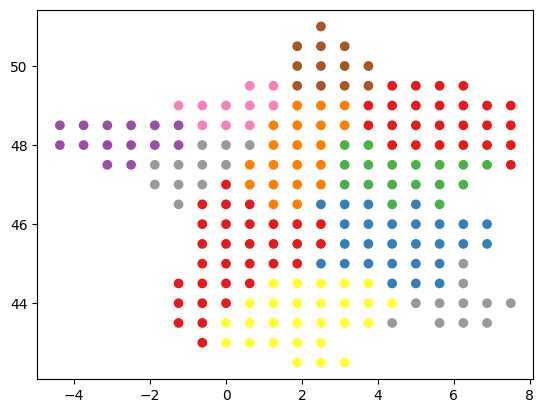

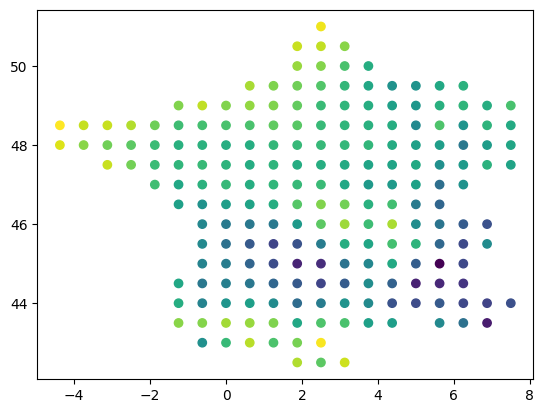

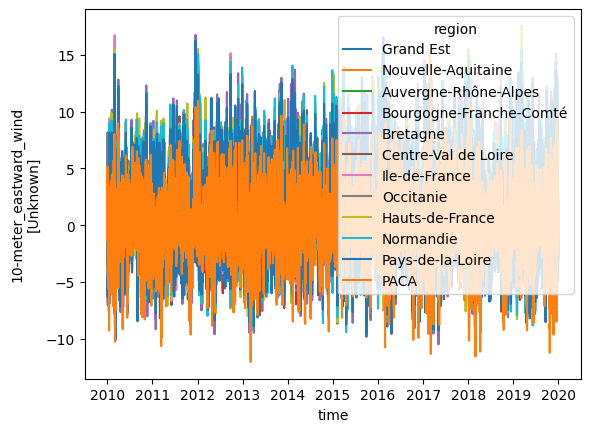

<Figure size 640x480 with 0 Axes>

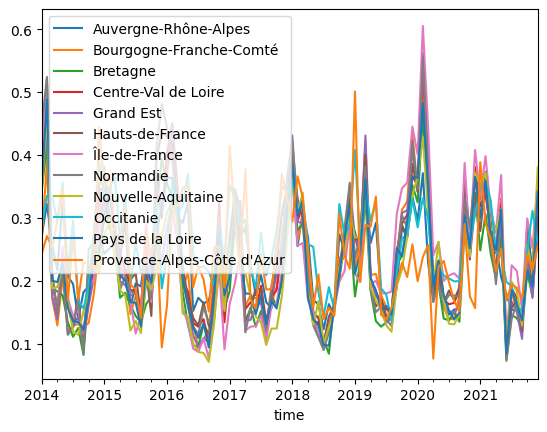

In [3]:
# Directories where you saved the data
data_dir_energy = Path('energy_france')
data_dir_climate = Path('climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_zonal_wind = xr.load_dataset(filepath)[variable_name]
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_zonal_wind.mean('time'))

variable_name = 'meridional_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_meridional_wind = xr.load_dataset(filepath)[variable_name]

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_zonal_wind.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()



In [4]:
wind_array = np.sqrt(da_meridional_wind**2 + da_zonal_wind**2)

monthly_wind_mean = wind_array.resample(time='1ME').mean()

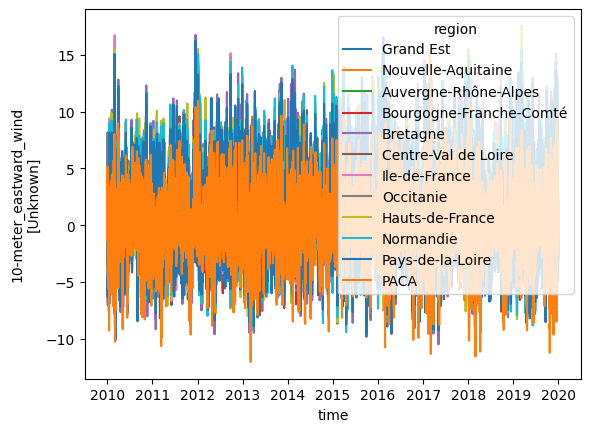

In [5]:
da_wind_reg = monthly_wind_mean.groupby(da_mask).mean().rename(mask='region')
da_wind_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')
plt.show()

In [6]:
da_wind_reg = da_wind_reg.sel(time=slice('2014-01-01', '2019-12-31'))

In [7]:
df_energy = df_energy[:72]

In [8]:
print(df_energy.shape)
print(da_wind_reg.shape)

(72, 12)
(72, 12)


In [9]:
#Test Regression lineaire avec une région
df_energy = df_energy.rename(columns={"Île-de-France": "Ile-de-France", "Pays de la Loire":"Pays-de-la-Loire", "Provence-Alpes-Côte d'Azur": "PACA"})
regions = da_wind_reg.coords['region'].values
data_normandie = da_wind_reg.sel(region='Normandie')
energy_normandie = df_energy['Normandie']

In [10]:
from sklearn.linear_model import LinearRegression

Lr = LinearRegression()

Lr.fit(data_normandie.values.reshape(-1,1), energy_normandie.values)

LinearRegression()

In [11]:
Lr.score(data_normandie.values.reshape(-1,1),energy_normandie.values)

0.9554566883105111

In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Lr.predict(data_normandie.values.reshape(-1,1)), energy_normandie.values)

0.000492763401518367

[]

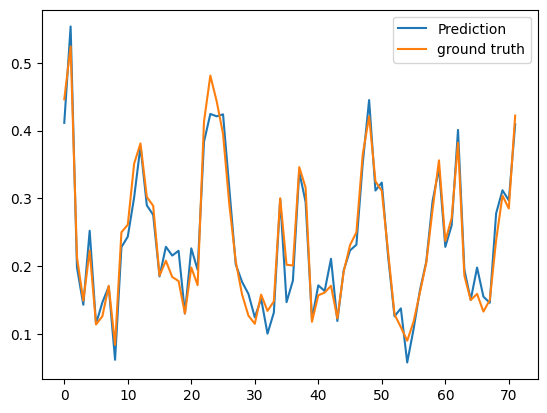

In [13]:
import numpy as np
predicted_capacity_factor = Lr.predict(data_normandie.values.reshape(-1,1))


x = np.arange(0,len(predicted_capacity_factor))

plt.figure()
plt.plot(x,predicted_capacity_factor, label = "Prediction")
plt.plot(x, energy_normandie.values, label = "ground truth")
plt.legend()
plt.plot()

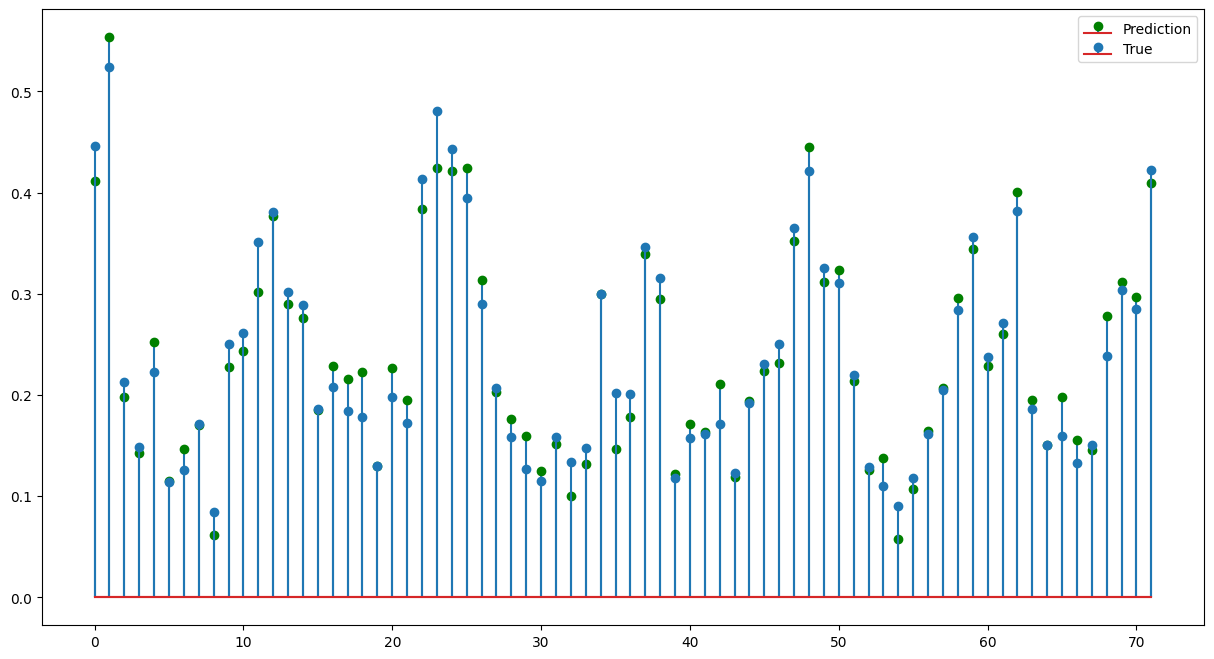

In [14]:
plt.figure(figsize = (15,8))
plt.stem(predicted_capacity_factor, label = 'Prediction', markerfmt= "g")
plt.stem(energy_normandie.values, label = "True")
plt.legend()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_normandie.values.reshape(-1,1), energy_normandie, test_size=0.33, random_state=42)

In [16]:
Lr = LinearRegression()

Lr.fit(X_train, y_train)

Lr.score(X_test,y_test)

0.9488676203670192

[]

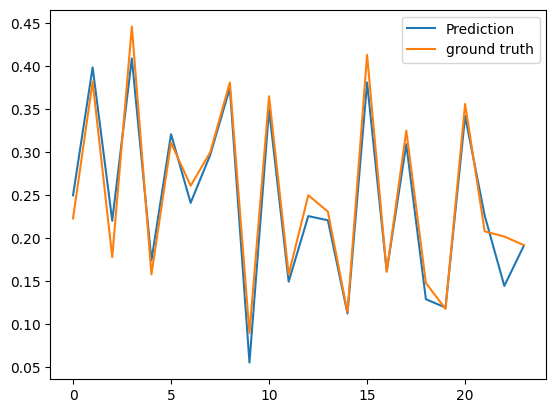

In [17]:
prediction = Lr.predict(X_test)

x = np.arange(0,len(prediction))

plt.figure()
plt.plot(x,prediction, label = "Prediction")
plt.plot(x, y_test.values, label = "ground truth")
plt.legend()
plt.plot()

In [18]:
# Density Extraction

variable_name = 'surface_density'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_surface_density = xr.load_dataset(filepath)[variable_name]

da_surface_density_montlhy = da_surface_density.resample(time='1ME').mean()
da_surface_density_reg = da_surface_density_montlhy.groupby(da_mask).mean().rename(mask='region')
da_surface_density_reg['region'] = ds_mask['region'].values
da_surface_density_reg = da_surface_density_reg.sel(time=slice('2014-01-01', '2019-12-31'))

In [19]:
# Temperature 

variable_name = 'surface_temperature'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_surface_temp = xr.load_dataset(filepath)[variable_name]

da_surface_temp_montlhy = da_surface_temp.resample(time='1ME').mean()
da_surface_temp_reg = da_surface_temp_montlhy.groupby(da_mask).mean().rename(mask='region')
da_surface_temp_reg['region'] = ds_mask['region'].values
da_surface_temp_reg = da_surface_temp_reg.sel(time=slice('2014-01-01', '2019-12-31'))

In [20]:
#Height 500

variable_name = 'height_500'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_height_500 = xr.load_dataset(filepath)[variable_name]

da_height_500_montlhy = da_height_500.resample(time='1ME').mean()
da_height_500_reg = da_height_500_montlhy.groupby(da_mask).mean().rename(mask='region')
da_height_500_reg['region'] = ds_mask['region'].values
da_height_500_reg = da_height_500_reg.sel(time=slice('2014-01-01', '2019-12-31'))

In [21]:
def concat_array_to_dataset(data_climate_wind, region):
    data_climate = data_climate_wind.copy()
    
    data_climate = da_wind_reg.sel(region= region)
    
    data_capacity = df_energy[region]

    data_climate = data_climate.to_dataset(name="wind_speed") 
    data_climate["surface_density"] = da_surface_density_reg.sel(region=region)
    data_climate["surface_temperature"] = da_surface_temp_reg.sel(region=region)
    data_climate["height_500"] = da_height_500_reg.sel(region=region)
    
    return data_climate, data_capacity

In [22]:
def xarray_dataset_to_numpy(X_array, y_array):
    
    X = X_array.to_array().transpose("time", "variable").values.T
    y = y_array.values

    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test

In [23]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [42]:
def lassoModel(X_train, X_test, y_train, y_test, region):
    
    Lasso = linear_model.Lasso(max_iter = 10000)
    param_grid_ls = {'alpha': np.linspace(0.0001, 1.0, 50)}
    ls_cv = GridSearchCV(Lasso, param_grid_ls, cv=5)
    ls_cv.fit(X_train,y_train)

    best_lasso = ls_cv.best_estimator_

    coefs = best_lasso.coef_
    
    prediction = ls_cv.predict(X_test)
    
    x = np.linspace(0, 0.5, 1000)
    
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    fig.suptitle(f"Lasso results ({region})", fontsize=16)
    axs[0,0].plot(prediction, label = "Prediction")
    axs[0,0].plot(y_test, label = "ground truth")
    axs[0,0].legend()
    axs[0,0].set_title(f"Capacity Factor Prediciton VS Ground Truth (accuracy : {ls_cv.score(X_test, y_test) * 100:.2f} %)")
    axs[0,0].set_xlabel("Month")
    axs[0,0].set_ylabel("Capacity Factor")
    axs[0,0].grid()

    axs[0,1].scatter(y_test, prediction)
    axs[0,1].plot(x, x, c="r")
    axs[0,1].set_title("Scatter Prediction / Truth")
    axs[0,1].set_xlabel("True Capacity Factor")
    axs[0,1].set_ylabel("Prediction") 
    axs[0,1].grid()

    axs[1,0].stem(coefs)
    axs[1,0].set_title("Lasso Coefficients")
    axs[1,0].set_xlabel("Feature Number")
    axs[1,0].set_ylabel("Value")

    metrics = np.array(['R2', 'MSE', 'explained_variance'])
    r2 = ls_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, prediction)
    explained_variance = explained_variance_score(y_test, prediction)
    results_metric = np.array([r2, mse, explained_variance])
    
    bars = axs[1,1].bar(metrics, results_metric)
    axs[1,1].set_title("Metrics")
    axs[1,1].set_ylabel("Value")
    axs[1, 1].bar_label(bars, padding = 8, color='black', fontsize=12)

    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    plt.show()

    return  ls_cv.score(X_test, y_test)

In [43]:
def Lasso_monitor(region):
    data_wind = da_wind_reg.sel(region=region).copy()

    data_climate, data_capacity = concat_array_to_dataset(data_wind, region)
    X_train, X_test, y_train, y_test = xarray_dataset_to_numpy(data_climate, data_capacity)
    lassoModel(X_train, X_test, y_train, y_test, region)
    

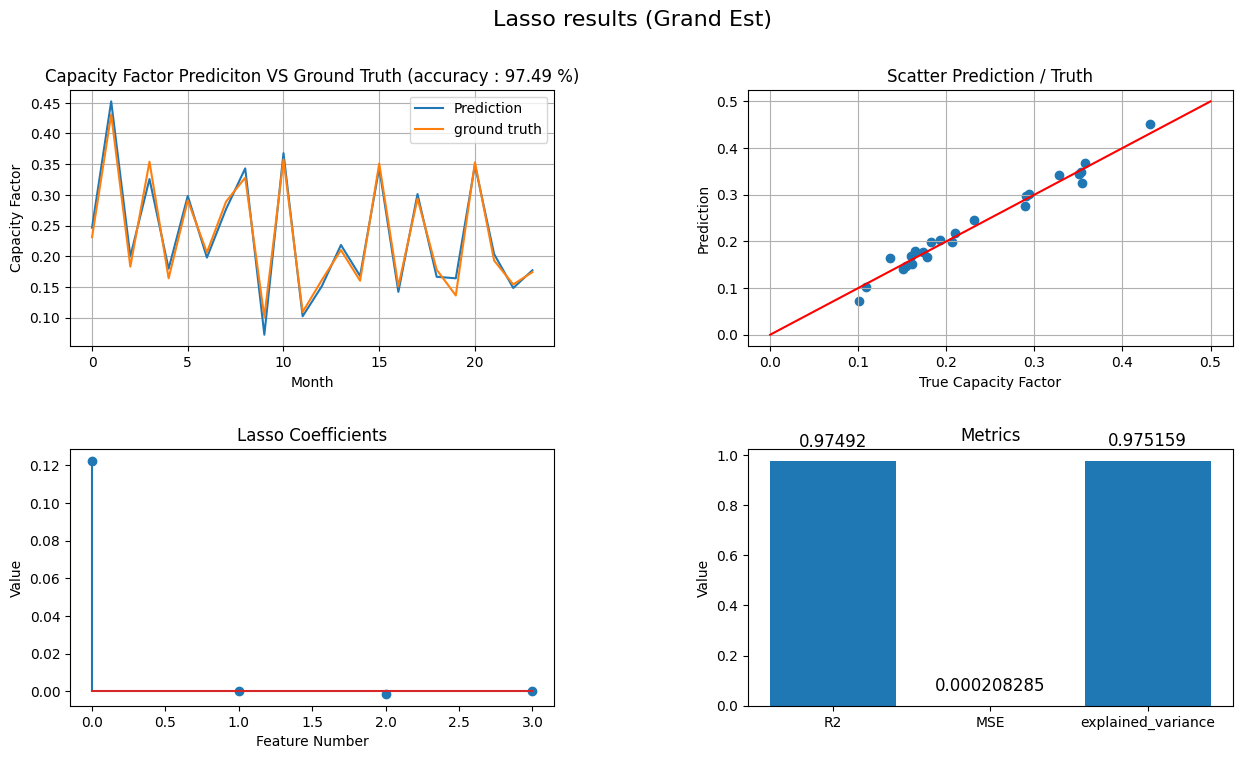

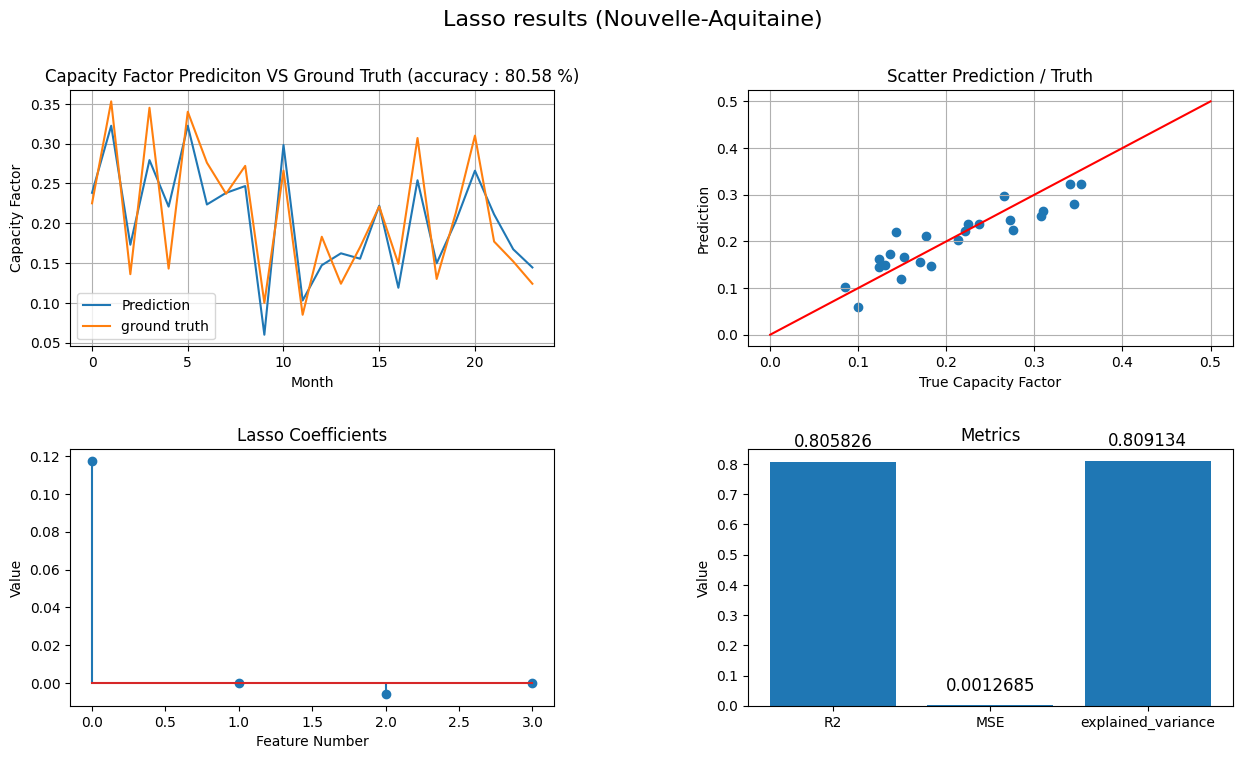

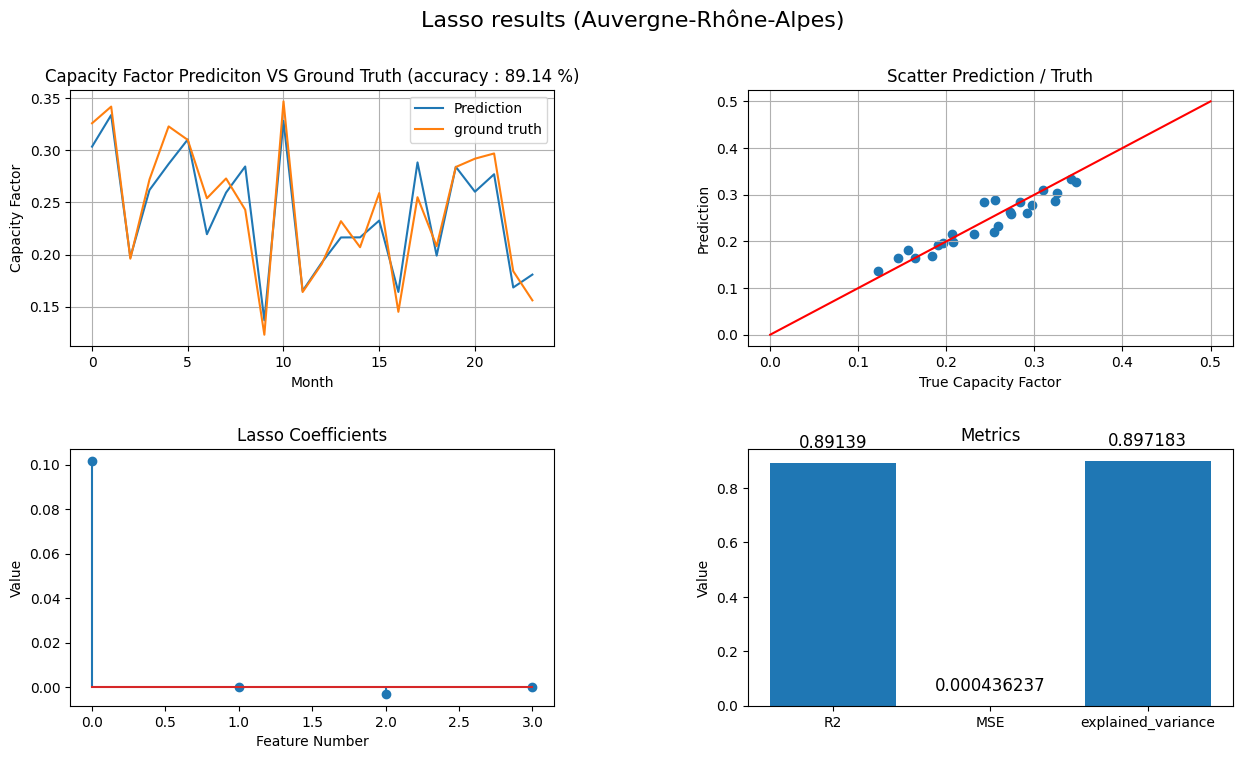

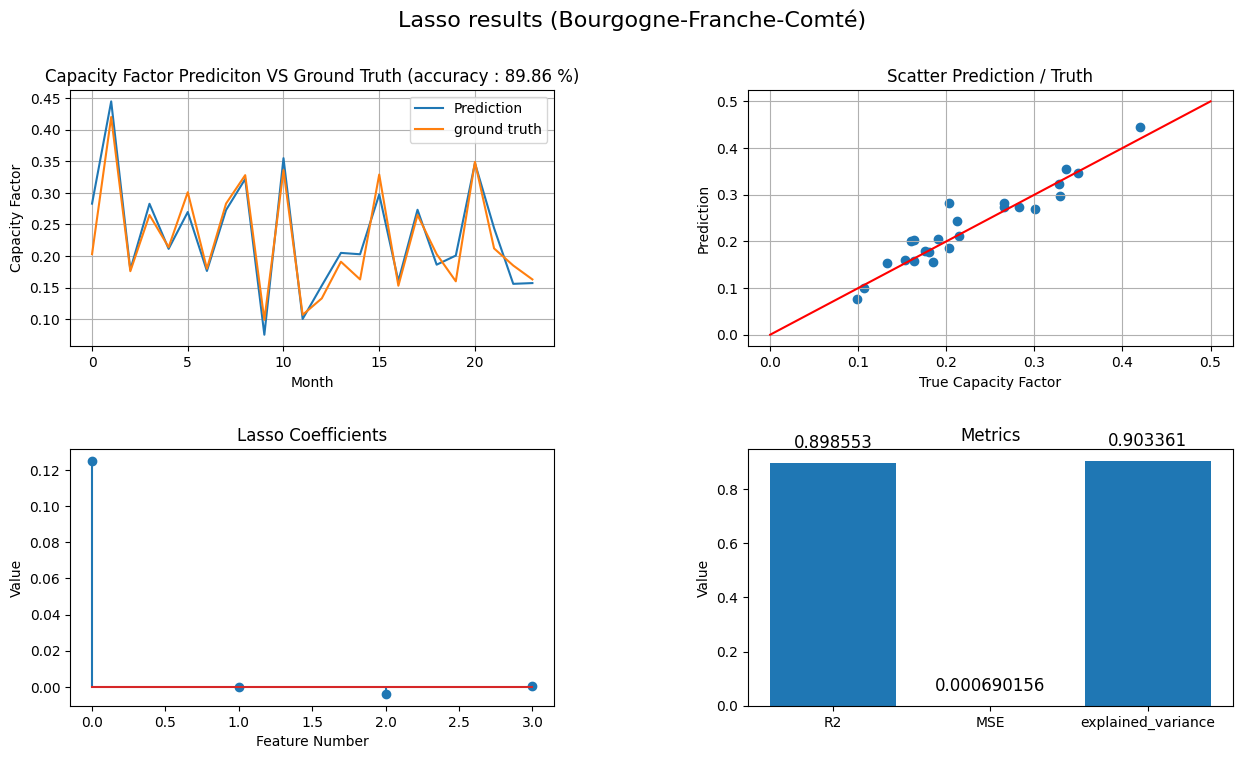

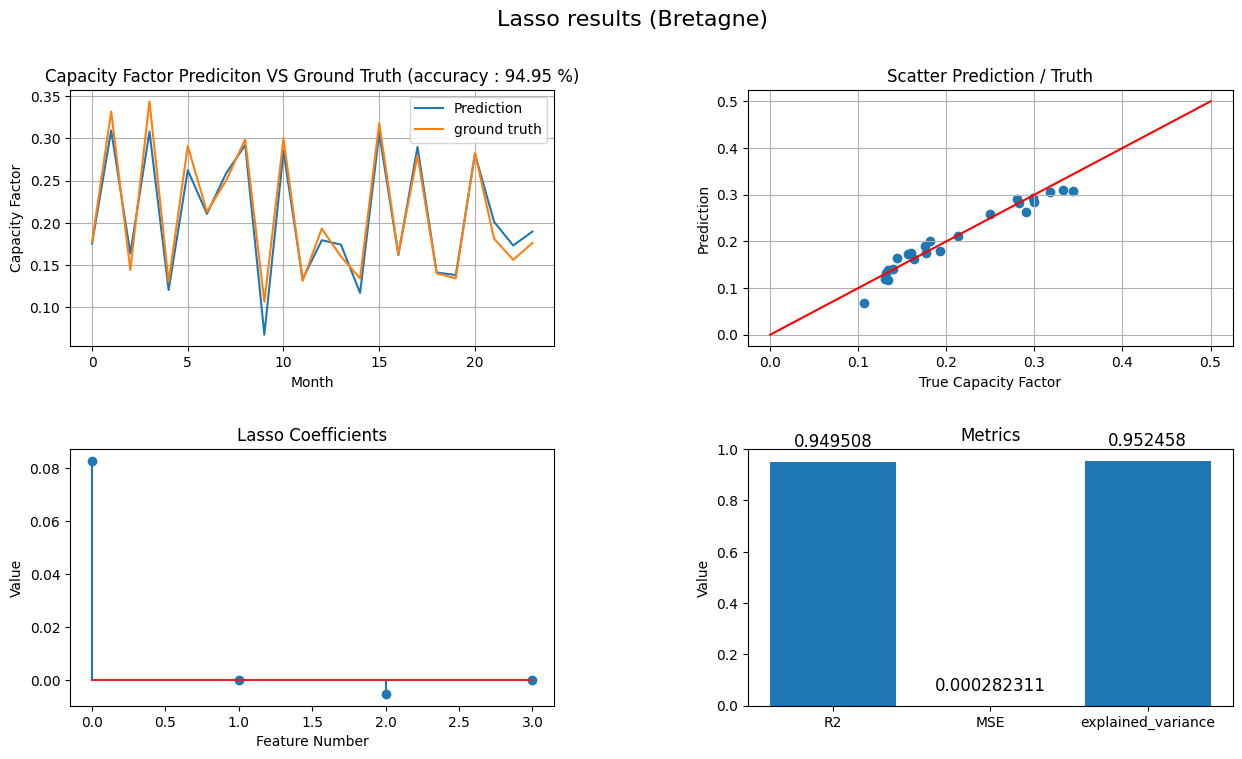

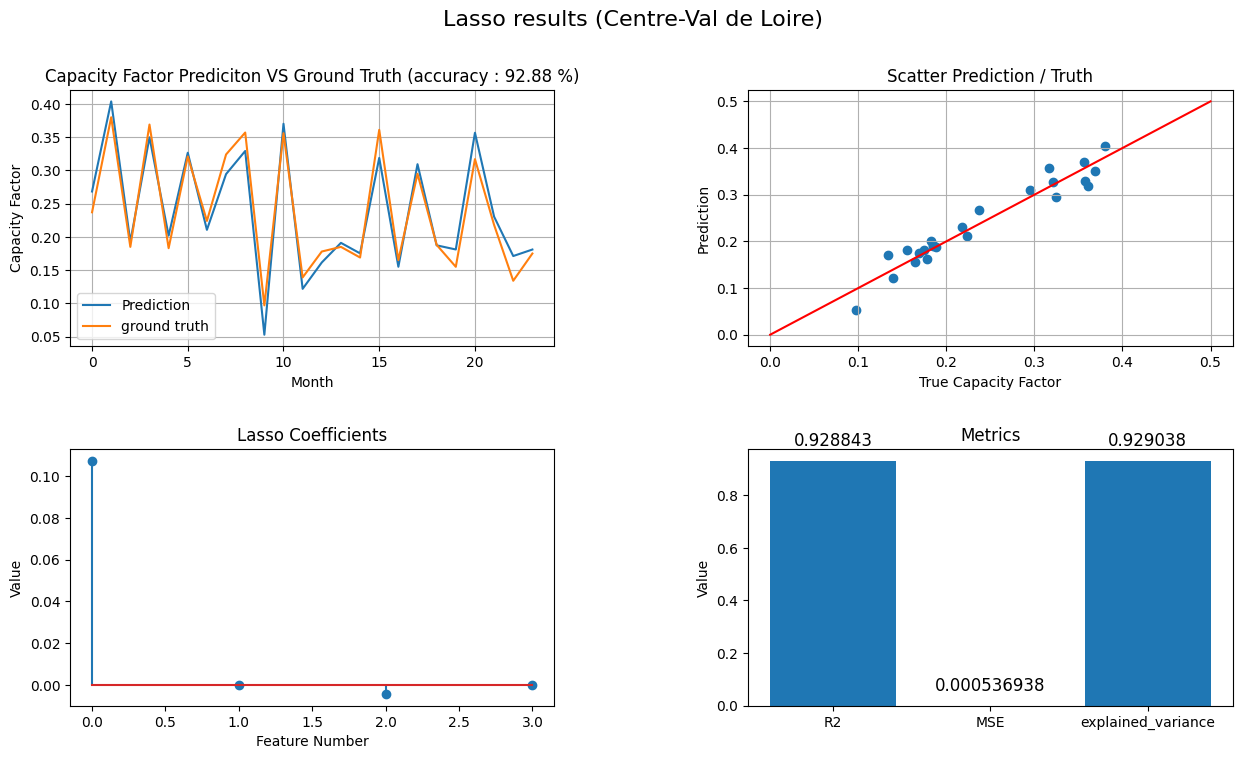

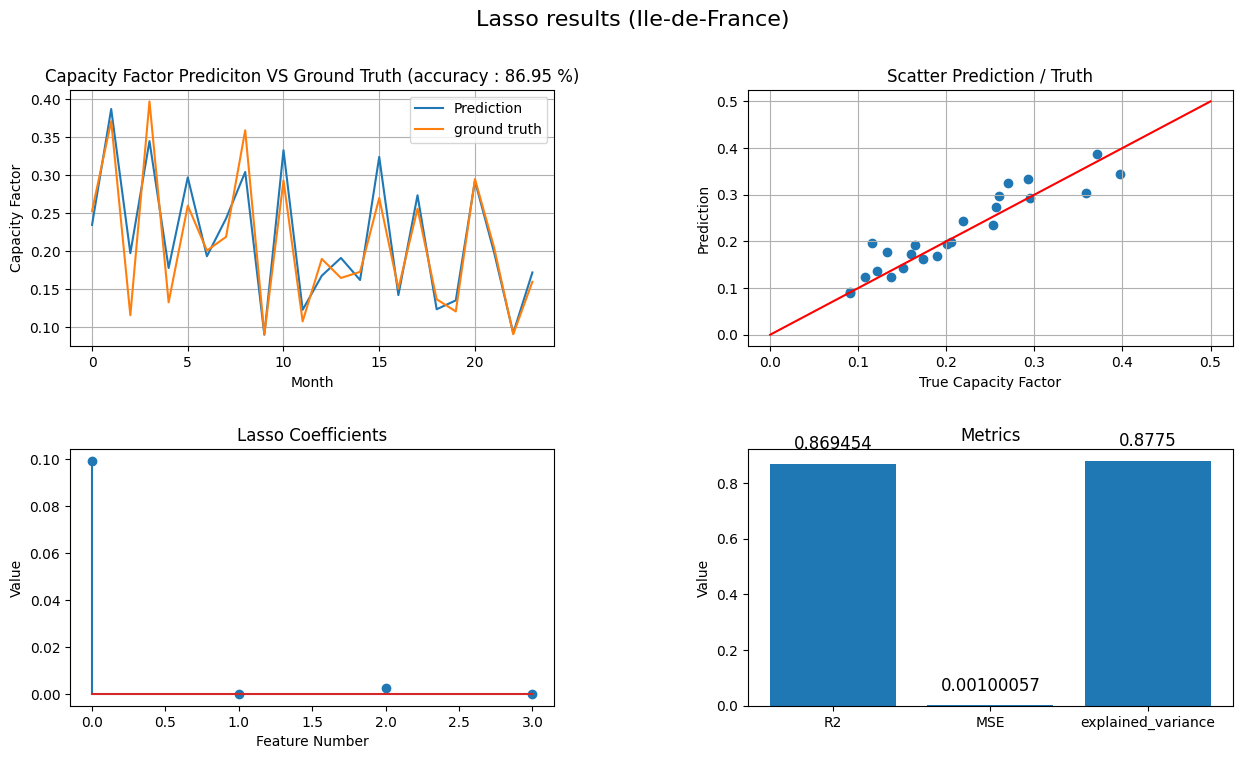

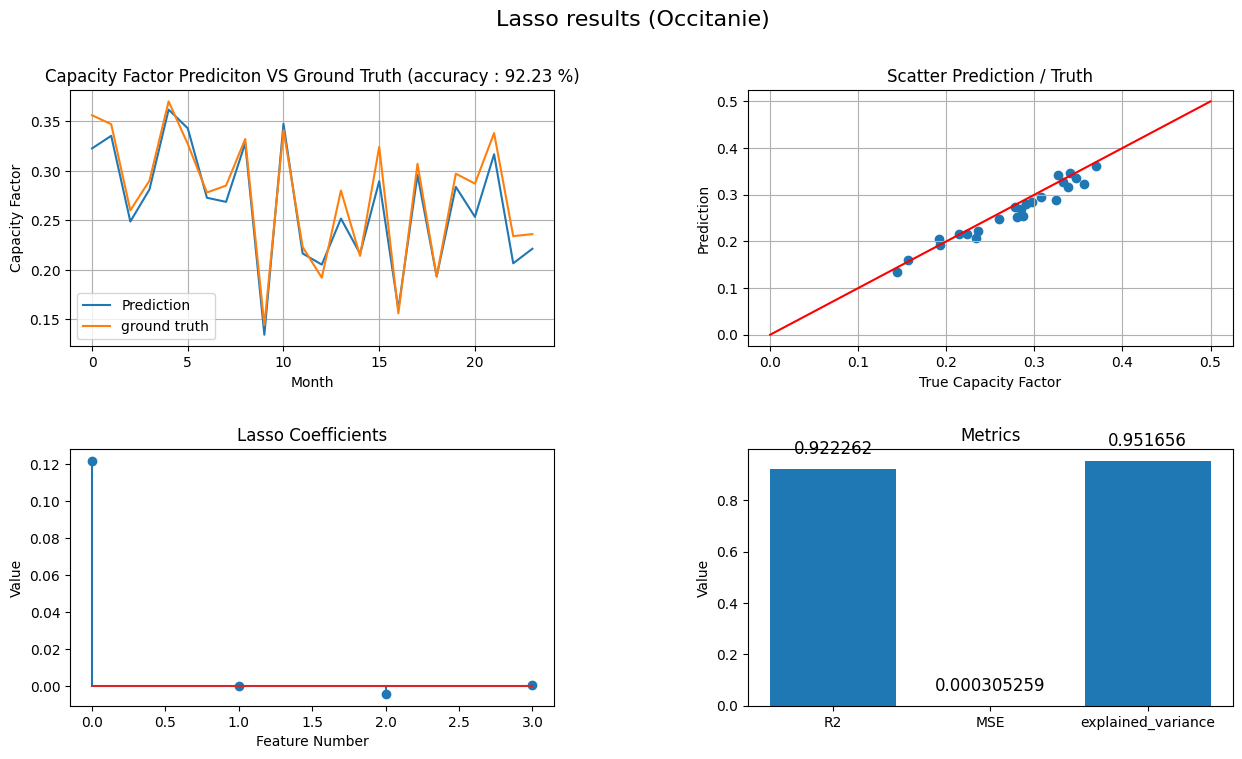

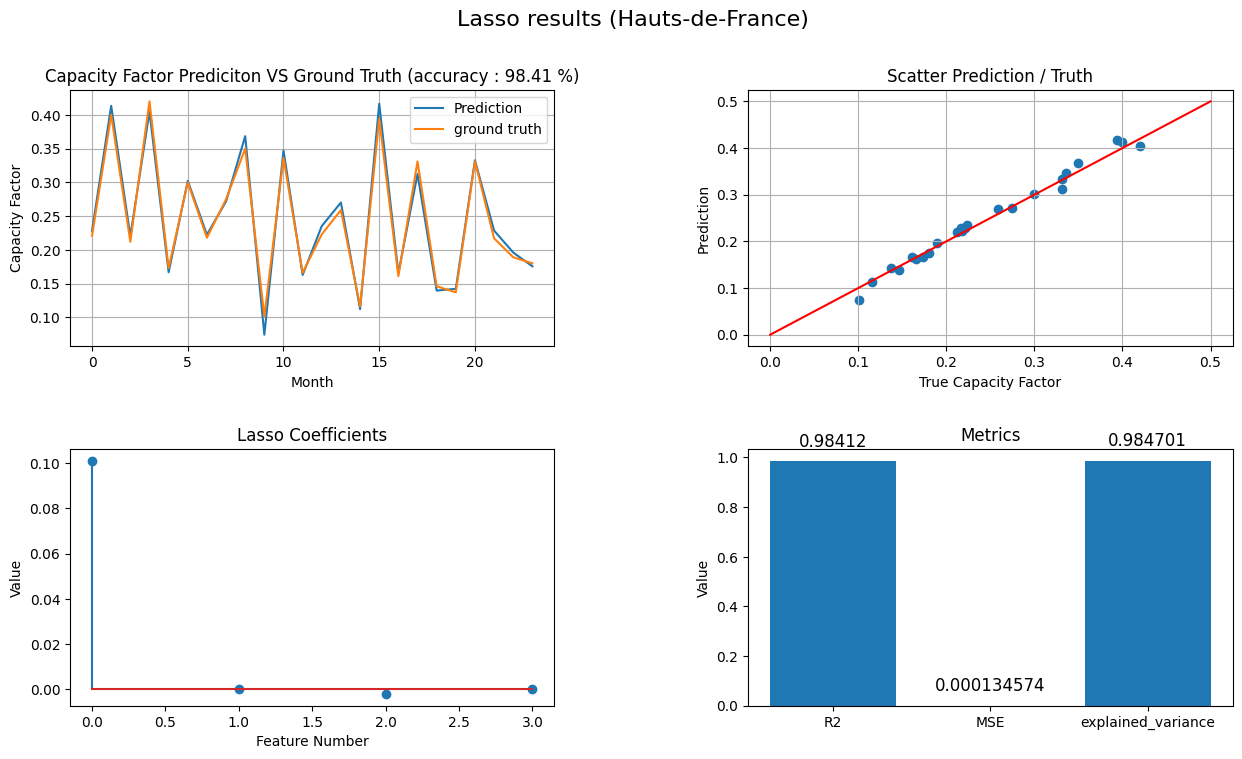

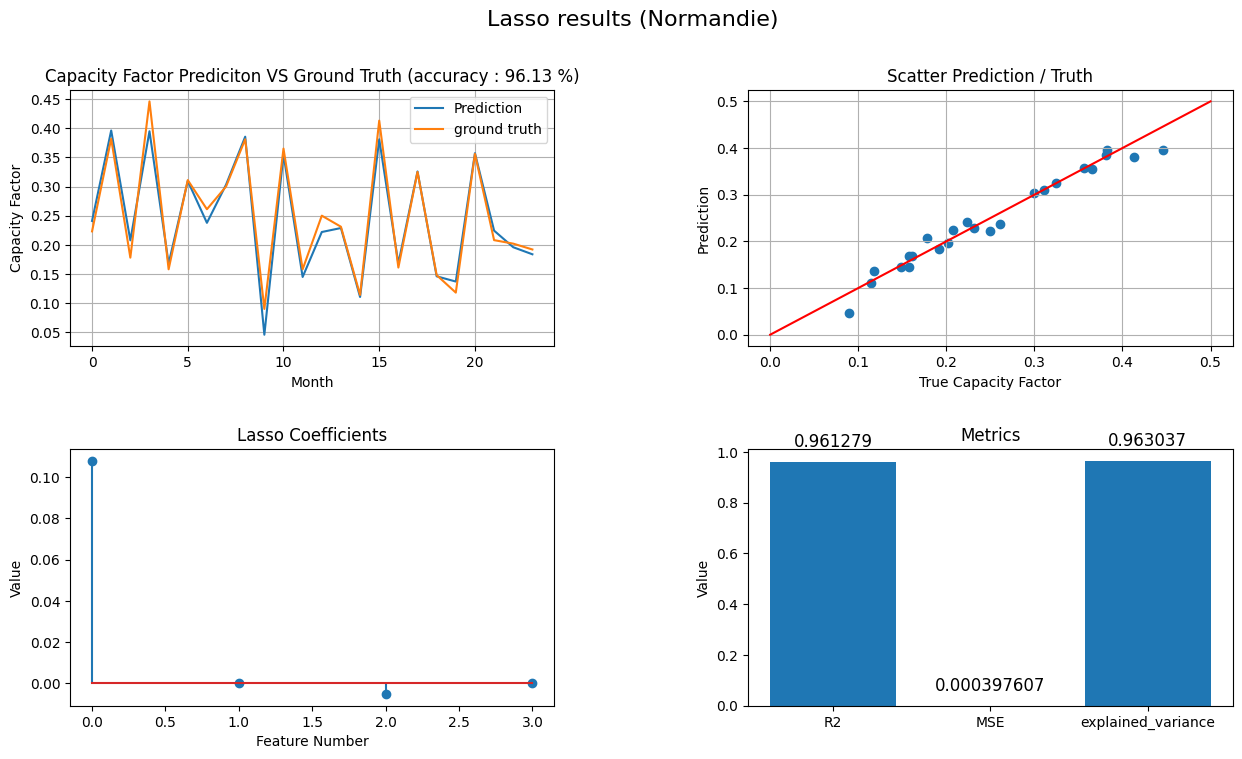

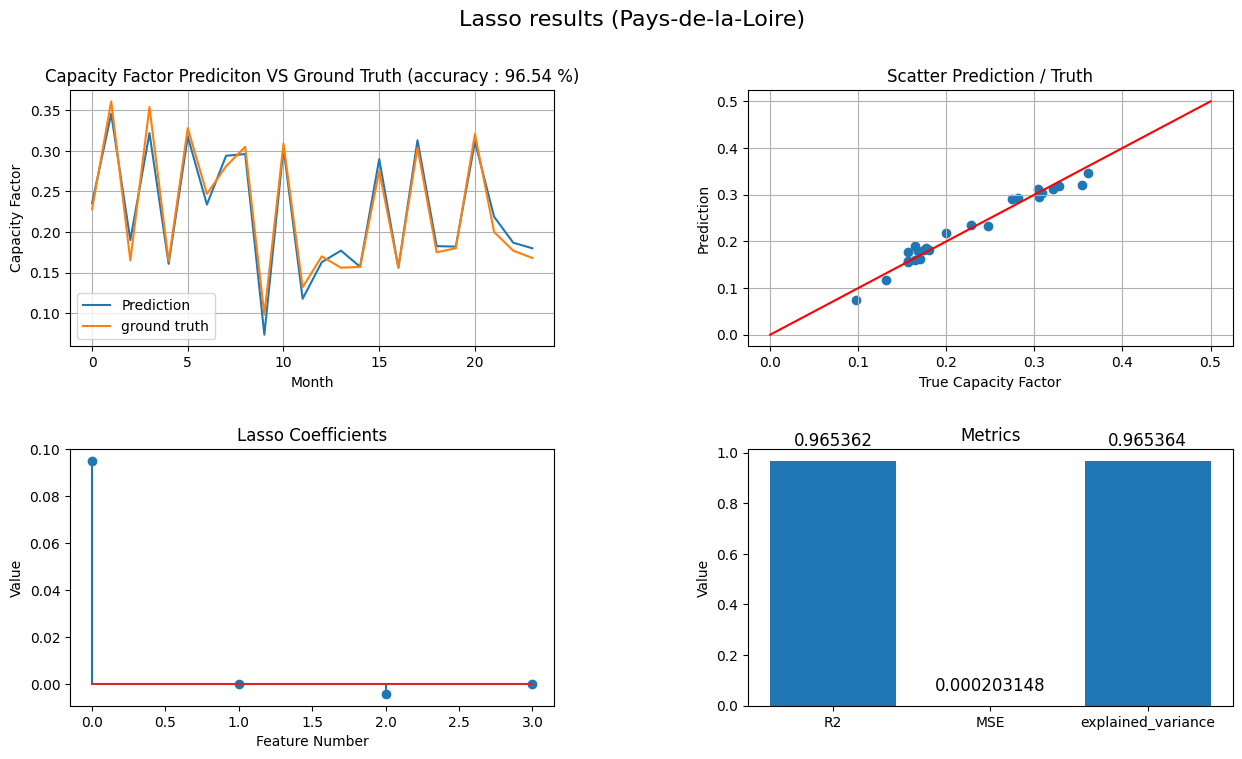

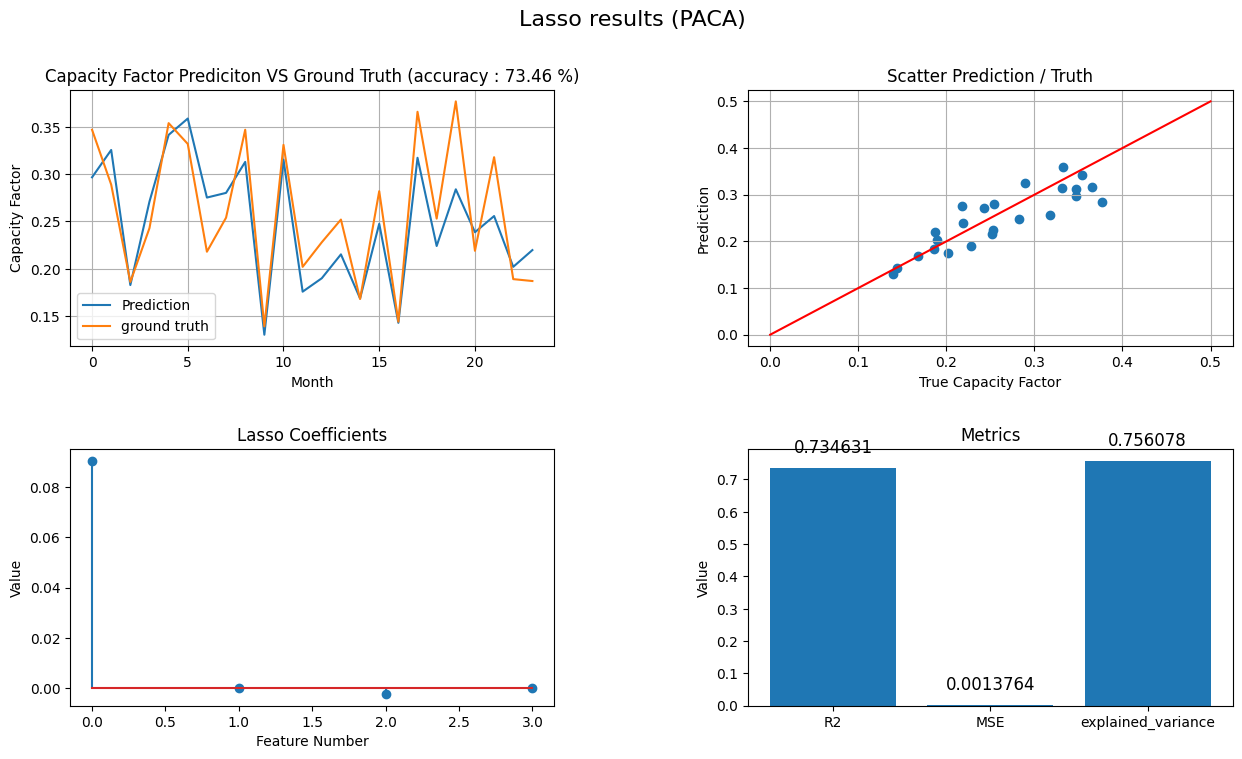

In [44]:
for region in regions:
    Lasso_monitor(region)

## Méthodes non linéaire

In [27]:
from sklearn.kernel_ridge import KernelRidge

def KernelRidgeModel(X_train, X_test, y_train, y_test, region):
    
    
    Kr = KernelRidge()
    param_grid = {
        'alpha': np.logspace(-6, 6, 13),  # Paramètre de régularisation, de 10^-6 à 10^6
        'kernel': ['linear', 'polynomial', 'rbf', 'sigmoid'],  # Types de noyaux
        'degree': [2, 3, 4],  # Degré du noyau polynomial (n'est pertinent que pour le 'polynomial')
        'gamma': ['scale', 'auto']  # Paramètre pour le noyau 'rbf' et 'sigmoid'
    }
    
    kr_cv = GridSearchCV(Kr, param_grid, cv=5)
    kr_cv.fit(X_train,y_train)

    best_kr = kr_cv.best_estimator_

    coefs = best_kr.dual_coef_
    
    prediction = kr_cv.predict(X_test)
    
    x = np.linspace(0, 0.5, 1000)
    
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    fig.suptitle(f"Kernel Ridge results ({region})", fontsize=16)
    axs[0,0].plot(prediction, label = "Prediction")
    axs[0,0].plot(y_test, label = "ground truth")
    axs[0,0].legend()
    axs[0,0].set_title("Capacity Factor Prediciton VS Ground Truth")
    axs[0,0].set_xlabel("Month")
    axs[0,0].set_ylabel("Capacity Factor")
    axs[0,0].grid()

    
    axs[0,1].scatter(y_test, prediction)
    axs[0,1].plot(x, x, c="r")
    axs[0,1].set_title("Scatter Prediction / Truth")
    axs[0,1].set_xlabel("True Capacity Factor")
    axs[0,1].set_ylabel("Prediction") 
    axs[0,1].grid()

    axs[1, 0].text(0.5, 0.5, 'SVR does not provide coefficients', ha='center', va='center', fontsize=12)
    axs[1, 0].set_title("SVR Coefficients (N/A)")
    axs[1, 0].axis('off')  # On éteint les axes pour cette partie


    metrics = np.array(['R2', 'MSE', 'explained_variance'])
    r2 = kr_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, prediction)
    explained_variance = explained_variance_score(y_test, prediction)
    results_metric = np.array([r2, mse, explained_variance])
    
    bars = axs[1,1].bar(metrics, results_metric)
    axs[1,1].set_title("Metrics")
    axs[1,1].set_ylabel("Value")
    axs[1, 1].bar_label(bars, padding = 8, color='black', fontsize=12)

    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    plt.show()

    

    return  kr_cv.score(X_test, y_test) 


In [28]:
def KernelRidge_monitor(region):
    data_wind = da_wind_reg.sel(region=region).copy()

    data_climate, data_capacity = concat_array_to_dataset(data_wind, region)
    X_train, X_test, y_train, y_test = xarray_dataset_to_numpy(data_climate, data_capacity)
    KernelRidgeModel(X_train, X_test, y_train, y_test, region)

In [29]:
KernelRidge_monitor("Normandie")

ValueError: 
All the 1560 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
780 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\kernel_ridge.py", line 193, in fit
    self._validate_params()
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'gamma' parameter of KernelRidge must be a float in the range [0, inf) or None. Got 'scale' instead.

--------------------------------------------------------------------------------
780 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\kernel_ridge.py", line 193, in fit
    self._validate_params()
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\users\romeo\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'gamma' parameter of KernelRidge must be a float in the range [0, inf) or None. Got 'auto' instead.


In [ ]:
from sklearn.svm import SVR
def SVRModel(X_train, X_test, y_train, y_test, region):
    
    # Instancier le modèle SVR
    svr = SVR()
    
    # Définir la grille des paramètres
    param_grid = {
        'C': np.logspace(-6, 6, 13),  # Paramètre de régularisation (contrôle la complexité du modèle)
        'epsilon': [0.01, 0.1, 0.2, 0.5],  # Paramètre d'epsilon (tolérance pour la régression)
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Types de noyaux à tester
        'degree': [2, 3, 4]  # Degré pour le noyau polynomial (pertinent pour 'poly')
    }


    svr_cv = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1)
    svr_cv.fit(X_train, y_train)

    best_svr = svr_cv.best_estimator_

    prediction = best_svr.predict(X_test)


    r2 = svr_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, prediction)
    explained_variance = explained_variance_score(y_test, prediction)

    metrics = np.array(['R2', 'MSE', 'Explained Variance'])
    results_metric = np.array([r2, mse, explained_variance])

    x = np.linspace(0, 0.5, 1000)

    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle(f"SVR Results ({region})", fontsize=16)
    

    axs[0, 0].plot(prediction, label="Prediction")
    axs[0, 0].plot(y_test, label="Ground Truth")
    axs[0, 0].legend()
    axs[0, 0].set_title("SVR Prediction VS Ground Truth")
    axs[0, 0].set_xlabel("Month")
    axs[0, 0].set_ylabel("Capacity Factor")
    axs[0, 0].grid()


    axs[0, 1].scatter(y_test, prediction)
    axs[0, 1].plot(x, x, c="r")
    axs[0, 1].set_title("Scatter: Prediction vs Ground Truth")
    axs[0, 1].set_xlabel("True Capacity Factor")
    axs[0, 1].set_ylabel("Prediction")
    axs[0, 1].grid()


    axs[1, 0].text(0.5, 0.5, 'SVR does not provide coefficients', ha='center', va='center', fontsize=12)
    axs[1, 0].set_title("SVR Coefficients (N/A)")
    axs[1, 0].axis('off')  

    bars = axs[1, 1].bar(metrics, results_metric)
    axs[1, 1].set_title("Metrics")
    axs[1, 1].set_ylabel("Value")
    axs[1, 1].bar_label(bars, padding=8, color='black', fontsize=12)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

    # Retourner la performance du modèle
    return svr_cv.score(X_test, y_test)



In [ ]:
def SVR_monitor(region):
    data_wind = da_wind_reg.sel(region=region).copy()

    data_climate, data_capacity = concat_array_to_dataset(data_wind, region)
    X_train, X_test, y_train, y_test = xarray_dataset_to_numpy(data_climate, data_capacity)
    SVRModel(X_train, X_test, y_train, y_test, region)

In [ ]:
SVR_monitor("Normandie")

## Data Augmentation

In [ ]:
def reshapeArray(array):
    array = array.groupby(da_mask).mean().rename(mask='region')
    array['region'] = ds_mask['region'].values
    array = array.sel(time=slice('2014-01-01', '2019-12-31'))
    return array

In [ ]:
#WIND SPEED
monthly_wind_min = wind_array.resample(time='1ME').min()
monthly_wind_max = wind_array.resample(time='1ME').max()
monthly_wind_std = wind_array.resample(time='1ME').std()
monthly_wind_var = wind_array.resample(time='1ME').var()


da_wind_reg_min = reshapeArray(monthly_wind_min)
da_wind_reg_max = reshapeArray(monthly_wind_max)
da_wind_reg_std = reshapeArray(monthly_wind_std)
da_wind_reg_var = reshapeArray(monthly_wind_var)

wind_array_cube = wind_array**3
wind_array_cube = wind_array_cube.resample(time='1ME').mean()
wind_array_cube = reshapeArray(wind_array_cube)

In [ ]:
def add_feature_dataset(dataset, region):
    data_climate = dataset.copy()

    
    data_climate["wind_min"] = da_wind_reg_min.sel(region=region)
    data_climate["wind_max"] = da_wind_reg_max.sel(region=region)
    data_climate["wind_std"] = da_wind_reg_std.sel(region=region)
    data_climate["wind_var"] = da_wind_reg_var.sel(region=region)
    data_climate["wind_cube"] = wind_array_cube.sel(region=region)
    
    return data_climate

In [ ]:
def LassoMonitor_with_new_features(region):
    data_wind = da_wind_reg.sel(region=region).copy()
    data_climate, data_capacity = concat_array_to_dataset(data_wind, region)
    data_climate = add_feature_dataset(data_climate, region)
    X_train, X_test, y_train, y_test = xarray_dataset_to_numpy(data_climate, data_capacity)
    lassoModel(X_train, X_test, y_train, y_test, region)
    
    

In [ ]:
LassoMonitor_with_new_features("Normandie")